In [1]:
#https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [2]:
# Per avere UNA SOLA PREDIZIONE:
#   numero sequence di dataset_test = n_past + n_future
#   esempio: dataset_train, dataset_test = dataset[1:4980], dataset[4979:] && n_past = 16 && n_future = 5

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [4]:
#--------------------- Data Preprocessing --------------------#
# Importing and scaling the data
#dataset_train = pd.read_csv("Bitcoin_Stock_Price_Trainset.csv")
#dataset_train = pd.read_csv('https://github.com/danber93/bitcoin_price_prediction/blob/main/data/Google_Stock_Price_Trainset.csv', skiprows=1)
dataset = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
dataset = dataset.tail(3000)
print(dataset.shape)
dataset

(3000, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
327483,1600036740000,2020-09-13 22:39:00,BTC/USDT,10298.88,10298.89,10292.51,10296.52,17.244495,177534.550916,289
327484,1600036680000,2020-09-13 22:38:00,BTC/USDT,10300.89,10300.89,10296.10,10298.89,15.013661,154609.680902,445
327485,1600036620000,2020-09-13 22:37:00,BTC/USDT,10298.23,10303.27,10297.67,10300.89,13.120003,135124.459010,339
327486,1600036560000,2020-09-13 22:36:00,BTC/USDT,10300.04,10300.41,10298.15,10298.23,8.386772,86376.185663,265
327487,1600036500000,2020-09-13 22:35:00,BTC/USDT,10297.91,10303.38,10297.91,10300.06,23.545223,242527.273000,414
...,...,...,...,...,...,...,...,...,...,...
330478,1599857040000,2020-09-11 20:44:00,BTC/USDT,10318.99,10319.72,10316.58,10319.47,14.466964,149266.708094,284
330479,1599856980000,2020-09-11 20:43:00,BTC/USDT,10319.34,10320.14,10318.89,10319.00,13.548103,139806.963489,187
330480,1599856920000,2020-09-11 20:42:00,BTC/USDT,10319.50,10320.31,10318.49,10319.34,12.123487,125108.931436,193
330481,1599856860000,2020-09-11 20:41:00,BTC/USDT,10316.00,10321.09,10316.00,10319.50,16.328427,168497.705251,256


In [5]:
# Building features
dataset['diff_pct_1'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(1)))) * 100) - 100
dataset['diff_pct_5'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(5)))) * 100) - 100
dataset['diff_pct_15'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(15)))) * 100) - 100
dataset['diff_pct_22'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(22)))) * 100) - 100

print(dataset)

                 unix                 date  ... diff_pct_15  diff_pct_22
327483  1600036740000  2020-09-13 22:39:00  ...   -0.190961    -0.299493
327484  1600036680000  2020-09-13 22:38:00  ...   -0.185984    -0.275386
327485  1600036620000  2020-09-13 22:37:00  ...   -0.145310    -0.209832
327486  1600036560000  2020-09-13 22:36:00  ...   -0.134018    -0.225162
327487  1600036500000  2020-09-13 22:35:00  ...   -0.144257    -0.199019
...               ...                  ...  ...         ...          ...
330478  1599857040000  2020-09-11 20:44:00  ...   -0.029838    -0.118374
330479  1599856980000  2020-09-11 20:43:00  ...   -0.023931    -0.111321
330480  1599856920000  2020-09-11 20:42:00  ...   -0.012209    -0.083850
330481  1599856860000  2020-09-11 20:41:00  ...   -0.002616    -0.080075
330482  1599856800000  2020-09-11 20:40:00  ...   -0.019481    -0.112224

[3000 rows x 14 columns]


In [6]:
# Drop useless columns REFACTOR perché devo aggiungere le colonne per le features
#dataset = dataset.iloc[:,6:8].values
print(dataset.columns)
dataset = dataset.iloc[:, [6, 10, 11, 12, 13]]
print(dataset)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'diff_pct_1', 'diff_pct_5', 'diff_pct_15',
       'diff_pct_22'],
      dtype='object')
           close  diff_pct_1  diff_pct_5  diff_pct_15  diff_pct_22
327483  10296.52   -0.188833   -0.222395    -0.190961    -0.299493
327484  10298.89    0.023017   -0.194883    -0.185984    -0.275386
327485  10300.89    0.019420   -0.178791    -0.145310    -0.209832
327486  10298.23   -0.025823   -0.206115    -0.134018    -0.225162
327487  10300.06    0.017770   -0.154517    -0.144257    -0.199019
...          ...         ...         ...          ...          ...
330478  10319.47   -0.029353    0.026171    -0.029838    -0.118374
330479  10319.00   -0.004554   -0.023156    -0.023931    -0.111321
330480  10319.34    0.003295   -0.013856    -0.012209    -0.083850
330481  10319.50    0.001550   -0.016083    -0.002616    -0.080075
330482  10316.00   -0.033916   -0.062969    -0.019481    -0.

In [7]:
# Split into train and test dataset
dataset_train, dataset_test = dataset[1:2936], dataset[2935:]
print(dataset_train.shape)
print(dataset_test.shape)
dataset_train = pd.DataFrame(dataset_train)
dataset_test = pd.DataFrame(dataset_test)

(2935, 5)
(65, 5)


In [8]:
train = dataset_train
scalers={}
for i in dataset_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = dataset_test
for i in dataset_test.columns:
    scaler = scalers['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    test[i]=s_s
print(test.shape)

(65, 5)


In [9]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  print(range(len(series)))
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [10]:
n_past = 50
n_future = 15
n_features = 5

In [11]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

range(0, 2935)
range(0, 65)


In [12]:
print(X_train.shape)

(2871, 50, 5)


In [13]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42400       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 15, 100)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 100)      80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [14]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 50, 100), (N 42400       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 15, 100)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [15]:
#checkpoint_filepath_e1d1 = '/content/checkpoints/model{epoch:d}'
filepath_e1d1 = '/content/e1d1_checkpoints/model{epoch:d}'
checkpoint_e1d1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_e1d1,
    period = 5)

filepath_e2d2 = '/content/e2d2_checkpoints/model{epoch:d}'
checkpoint_e2d2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_e2d2,
    period = 5)

In [16]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=125,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[checkpoint_e1d1, reduce_lr])
print()
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=125,validation_data=(X_test,y_test),batch_size=16,verbose=1,callbacks=[checkpoint_e2d2, reduce_lr])

Epoch 1/125
90/90 [==============================] - 10s 64ms/step - loss: 0.0071 - val_loss: 9.5682e-04
Epoch 2/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0053 - val_loss: 7.7846e-04
Epoch 3/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0053 - val_loss: 7.3725e-04
Epoch 4/125
90/90 [==============================] - 5s 53ms/step - loss: 0.0051 - val_loss: 5.9435e-04
Epoch 5/125
90/90 [==============================] - 5s 53ms/step - loss: 0.0051 - val_loss: 5.3205e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model5/assets


Epoch 6/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0050 - val_loss: 5.7149e-04
Epoch 7/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0050 - val_loss: 5.4497e-04
Epoch 8/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0050 - val_loss: 6.0053e-04
Epoch 9/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0049 - val_loss: 5.0343e-04
Epoch 10/125
90/90 [==============================] - 5s 53ms/step - loss: 0.0049 - val_loss: 5.4054e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model10/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model10/assets


Epoch 11/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0049 - val_loss: 7.1626e-04
Epoch 12/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0049 - val_loss: 5.0493e-04
Epoch 13/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0048 - val_loss: 5.3546e-04
Epoch 14/125
90/90 [==============================] - 5s 53ms/step - loss: 0.0048 - val_loss: 5.5574e-04
Epoch 15/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0048 - val_loss: 6.1828e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model15/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model15/assets


Epoch 16/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0048 - val_loss: 5.2787e-04
Epoch 17/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0047 - val_loss: 4.9855e-04
Epoch 18/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0047 - val_loss: 5.4192e-04
Epoch 19/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0047 - val_loss: 5.1052e-04
Epoch 20/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0047 - val_loss: 5.0640e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model20/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model20/assets


Epoch 21/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0047 - val_loss: 5.1419e-04
Epoch 22/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0046 - val_loss: 5.2838e-04
Epoch 23/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0046 - val_loss: 5.1994e-04
Epoch 24/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0046 - val_loss: 5.5294e-04
Epoch 25/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0046 - val_loss: 5.1917e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model25/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model25/assets


Epoch 26/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0046 - val_loss: 5.5577e-04
Epoch 27/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0046 - val_loss: 5.1879e-04
Epoch 28/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0046 - val_loss: 5.2947e-04
Epoch 29/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.5321e-04
Epoch 30/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.4580e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model30/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model30/assets


Epoch 31/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.2971e-04
Epoch 32/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3547e-04
Epoch 33/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0045 - val_loss: 5.6174e-04
Epoch 34/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0045 - val_loss: 5.2932e-04
Epoch 35/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0045 - val_loss: 5.4531e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model35/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model35/assets


Epoch 36/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0045 - val_loss: 5.4729e-04
Epoch 37/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.4308e-04
Epoch 38/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.4486e-04
Epoch 39/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3280e-04
Epoch 40/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3475e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model40/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model40/assets


Epoch 41/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3562e-04
Epoch 42/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.4394e-04
Epoch 43/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3478e-04
Epoch 44/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3628e-04
Epoch 45/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3459e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model45/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model45/assets


Epoch 46/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0045 - val_loss: 5.3430e-04
Epoch 47/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0045 - val_loss: 5.3622e-04
Epoch 48/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0045 - val_loss: 5.3425e-04
Epoch 49/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0045 - val_loss: 5.3347e-04
Epoch 50/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3089e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model50/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model50/assets


Epoch 51/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0045 - val_loss: 5.3355e-04
Epoch 52/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3247e-04
Epoch 53/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3215e-04
Epoch 54/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3218e-04
Epoch 55/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3219e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model55/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model55/assets


Epoch 56/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3127e-04
Epoch 57/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3343e-04
Epoch 58/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3240e-04
Epoch 59/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3262e-04
Epoch 60/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3216e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model60/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model60/assets


Epoch 61/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3205e-04
Epoch 62/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3259e-04
Epoch 63/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3200e-04
Epoch 64/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3237e-04
Epoch 65/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3246e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model65/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model65/assets


Epoch 66/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3210e-04
Epoch 67/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3237e-04
Epoch 68/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3241e-04
Epoch 69/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3213e-04
Epoch 70/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3249e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model70/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model70/assets


Epoch 71/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0044 - val_loss: 5.3214e-04
Epoch 72/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3188e-04
Epoch 73/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3230e-04
Epoch 74/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3198e-04
Epoch 75/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3195e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model75/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model75/assets


Epoch 76/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3206e-04
Epoch 77/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3200e-04
Epoch 78/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3207e-04
Epoch 79/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3201e-04
Epoch 80/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3199e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model80/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model80/assets


Epoch 81/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3210e-04
Epoch 82/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3198e-04
Epoch 83/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 84/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3192e-04
Epoch 85/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3189e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model85/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model85/assets


Epoch 86/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3197e-04
Epoch 87/125
90/90 [==============================] - 5s 58ms/step - loss: 0.0044 - val_loss: 5.3194e-04
Epoch 88/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3191e-04
Epoch 89/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3194e-04
Epoch 90/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3194e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model90/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model90/assets


Epoch 91/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3191e-04
Epoch 92/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3191e-04
Epoch 93/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 94/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3188e-04
Epoch 95/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3187e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model95/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model95/assets


Epoch 96/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3188e-04
Epoch 97/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3188e-04
Epoch 98/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 99/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3189e-04
Epoch 100/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3187e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model100/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model100/assets


Epoch 101/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 102/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 103/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 104/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3187e-04
Epoch 105/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model105/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model105/assets


Epoch 106/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 107/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 108/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 109/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 110/125
90/90 [==============================] - 5s 57ms/step - loss: 0.0044 - val_loss: 5.3186e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model110/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model110/assets


Epoch 111/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 112/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 113/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 114/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 115/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model115/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model115/assets


Epoch 116/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 117/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 118/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 119/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 120/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model120/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model120/assets


Epoch 121/125
90/90 [==============================] - 5s 56ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 122/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 123/125
90/90 [==============================] - 5s 54ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 124/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04
Epoch 125/125
90/90 [==============================] - 5s 55ms/step - loss: 0.0044 - val_loss: 5.3186e-04


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model125/assets


INFO:tensorflow:Assets written to: /content/e1d1_checkpoints/model125/assets



Epoch 1/125
180/180 [==============================] - 25s 101ms/step - loss: 0.0066 - val_loss: 7.7443e-04
Epoch 2/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0054 - val_loss: 7.1243e-04
Epoch 3/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0052 - val_loss: 8.1776e-04
Epoch 4/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0053 - val_loss: 0.0010
Epoch 5/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0051 - val_loss: 8.9030e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model5/assets


Epoch 6/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0050 - val_loss: 6.2363e-04
Epoch 7/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0050 - val_loss: 5.6528e-04
Epoch 8/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0049 - val_loss: 5.9897e-04
Epoch 9/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0048 - val_loss: 0.0010
Epoch 10/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0048 - val_loss: 6.2909e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model10/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model10/assets


Epoch 11/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0048 - val_loss: 9.6575e-04
Epoch 12/125
180/180 [==============================] - 16s 91ms/step - loss: 0.0047 - val_loss: 5.7925e-04
Epoch 13/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0046 - val_loss: 5.9574e-04
Epoch 14/125
180/180 [==============================] - 16s 91ms/step - loss: 0.0046 - val_loss: 5.3575e-04
Epoch 15/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0045 - val_loss: 5.9233e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model15/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model15/assets


Epoch 16/125
180/180 [==============================] - 16s 92ms/step - loss: 0.0044 - val_loss: 5.1799e-04
Epoch 17/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0043 - val_loss: 5.4774e-04
Epoch 18/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0042 - val_loss: 5.4553e-04
Epoch 19/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0043 - val_loss: 5.8037e-04
Epoch 20/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0041 - val_loss: 5.7753e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model20/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model20/assets


Epoch 21/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0040 - val_loss: 6.3677e-04
Epoch 22/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0040 - val_loss: 6.0499e-04
Epoch 23/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0039 - val_loss: 6.5121e-04
Epoch 24/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0038 - val_loss: 7.1424e-04
Epoch 25/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0038 - val_loss: 6.1194e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model25/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model25/assets


Epoch 26/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0037 - val_loss: 7.4953e-04
Epoch 27/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0037 - val_loss: 6.4949e-04
Epoch 28/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0037 - val_loss: 7.9383e-04
Epoch 29/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0036 - val_loss: 8.2793e-04
Epoch 30/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0036 - val_loss: 8.5895e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model30/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model30/assets


Epoch 31/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0036 - val_loss: 7.9691e-04
Epoch 32/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0035 - val_loss: 7.3112e-04
Epoch 33/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0035 - val_loss: 7.5918e-04
Epoch 34/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0035 - val_loss: 7.8883e-04
Epoch 35/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0035 - val_loss: 7.7915e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model35/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model35/assets


Epoch 36/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0034 - val_loss: 7.8234e-04
Epoch 37/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0034 - val_loss: 8.0198e-04
Epoch 38/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0034 - val_loss: 7.5827e-04
Epoch 39/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0034 - val_loss: 8.1604e-04
Epoch 40/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0033 - val_loss: 8.0586e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model40/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model40/assets


Epoch 41/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0033 - val_loss: 7.6899e-04
Epoch 42/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0033 - val_loss: 8.2780e-04
Epoch 43/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0033 - val_loss: 8.0808e-04
Epoch 44/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0033 - val_loss: 8.4045e-04
Epoch 45/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0032 - val_loss: 8.5676e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model45/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model45/assets


Epoch 46/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0032 - val_loss: 8.3986e-04
Epoch 47/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0032 - val_loss: 8.2918e-04
Epoch 48/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.5272e-04
Epoch 49/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0032 - val_loss: 8.1823e-04
Epoch 50/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.3554e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model50/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model50/assets


Epoch 51/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0032 - val_loss: 8.1703e-04
Epoch 52/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0032 - val_loss: 8.2019e-04
Epoch 53/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.3233e-04
Epoch 54/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.1512e-04
Epoch 55/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0032 - val_loss: 8.1823e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model55/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model55/assets


Epoch 56/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.2183e-04
Epoch 57/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.1899e-04
Epoch 58/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0032 - val_loss: 8.1921e-04
Epoch 59/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0031 - val_loss: 8.1583e-04
Epoch 60/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.1992e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model60/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model60/assets


Epoch 61/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0031 - val_loss: 8.2204e-04
Epoch 62/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0031 - val_loss: 8.1752e-04
Epoch 63/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1159e-04
Epoch 64/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1399e-04
Epoch 65/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1408e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model65/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model65/assets


Epoch 66/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.1465e-04
Epoch 67/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1205e-04
Epoch 68/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1285e-04
Epoch 69/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1146e-04
Epoch 70/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1165e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model70/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model70/assets


Epoch 71/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.1030e-04
Epoch 72/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0990e-04
Epoch 73/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.1168e-04
Epoch 74/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1062e-04
Epoch 75/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1101e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model75/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model75/assets


Epoch 76/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0031 - val_loss: 8.1009e-04
Epoch 77/125
180/180 [==============================] - 17s 92ms/step - loss: 0.0031 - val_loss: 8.1098e-04
Epoch 78/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.1017e-04
Epoch 79/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0967e-04
Epoch 80/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.1006e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model80/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model80/assets


Epoch 81/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.1003e-04
Epoch 82/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0965e-04
Epoch 83/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0954e-04
Epoch 84/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0935e-04
Epoch 85/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0980e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model85/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model85/assets


Epoch 86/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0991e-04
Epoch 87/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0977e-04
Epoch 88/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0981e-04
Epoch 89/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0970e-04
Epoch 90/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0966e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model90/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model90/assets


Epoch 91/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0976e-04
Epoch 92/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0961e-04
Epoch 93/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0948e-04
Epoch 94/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0945e-04
Epoch 95/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0952e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model95/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model95/assets


Epoch 96/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0963e-04
Epoch 97/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0949e-04
Epoch 98/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0953e-04
Epoch 99/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0950e-04
Epoch 100/125
180/180 [==============================] - 17s 96ms/step - loss: 0.0031 - val_loss: 8.0946e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model100/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model100/assets


Epoch 101/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0945e-04
Epoch 102/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0939e-04
Epoch 103/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0938e-04
Epoch 104/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0941e-04
Epoch 105/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0941e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model105/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model105/assets


Epoch 106/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 107/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0946e-04
Epoch 108/125
180/180 [==============================] - 17s 96ms/step - loss: 0.0031 - val_loss: 8.0942e-04
Epoch 109/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0945e-04
Epoch 110/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0945e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model110/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model110/assets


Epoch 111/125
180/180 [==============================] - 17s 93ms/step - loss: 0.0031 - val_loss: 8.0945e-04
Epoch 112/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0942e-04
Epoch 113/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 114/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 115/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model115/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model115/assets


Epoch 116/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 117/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 118/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 119/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 120/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model120/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model120/assets


Epoch 121/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 122/125
180/180 [==============================] - 17s 95ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 123/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 124/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04
Epoch 125/125
180/180 [==============================] - 17s 94ms/step - loss: 0.0031 - val_loss: 8.0943e-04


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model125/assets


INFO:tensorflow:Assets written to: /content/e2d2_checkpoints/model125/assets


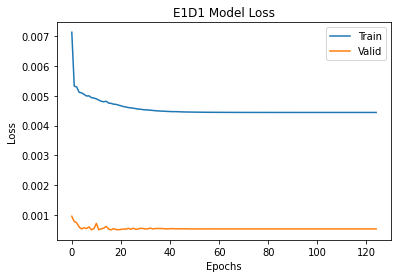

In [17]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

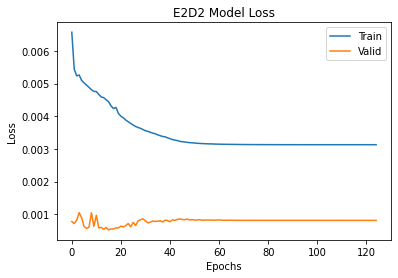

In [18]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [19]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

In [20]:
print(pred1_e1d1.shape)
print(pred1_e2d2.shape)

(1, 15, 5)
(1, 15, 5)


In [21]:
for index,i in enumerate(dataset_train.columns):
    scaler = scalers['scaler_'+ str(i)]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])

    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [22]:
#print(y_test)
print(y_test.shape, pred1_e1d1.shape, pred1_e2d2.shape)
print(pred1_e2d2)
print(y_test)
print(pred1_e1d1)

(1, 15, 5) (1, 15, 5) (1, 15, 5)
[[[ 1.03150244e+04  8.50929506e-03 -5.11200801e-02 -1.40827924e-01
   -8.61060843e-02]
  [ 1.03173262e+04  7.36394105e-03 -1.88944917e-02 -1.26156837e-01
   -7.85890743e-02]
  [ 1.03188242e+04  5.50549058e-03  3.85135273e-03 -1.19196452e-01
   -7.96636418e-02]
  [ 1.03198213e+04  3.87563696e-03  1.68094914e-02 -1.14124276e-01
   -8.48880857e-02]
  [ 1.03204688e+04  2.77740997e-03  2.16361657e-02 -1.07317820e-01
   -9.14270207e-02]
  [ 1.03208750e+04  2.26636534e-03  2.09675897e-02 -9.69504863e-02
   -9.77242216e-02]
  [ 1.03211162e+04  2.26812880e-03  1.75004434e-02 -8.26761872e-02
   -1.02825031e-01]
  [ 1.03212471e+04  2.65185232e-03  1.34866545e-02 -6.51671365e-02
   -1.06015623e-01]
  [ 1.03213125e+04  3.27129010e-03  1.04951197e-02 -4.56588976e-02
   -1.06699340e-01]
  [ 1.03213477e+04  3.98584642e-03  9.35147051e-03 -2.55845618e-02
   -1.04412027e-01]
  [ 1.03213848e+04  4.67160018e-03  1.02054942e-02 -6.31728256e-03
   -9.88901183e-02]
  [ 1.0321

In [23]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(dataset_train.columns):
  print(i)
  for j in range(1,n_future+1):
    print("Day ",j,":")
    print(y_test[:, j-1, index])
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()

close
Day  1 :
[10316.22]
MAE-E1D1 :  1.1237500000006548, MAE-E2D2 :  1.1955859374993452
Day  2 :
[10318.08]
MAE-E1D1 :  0.8348828124999272, MAE-E2D2 :  0.7538281249999272
Day  3 :
[10315.88]
MAE-E1D1 :  1.5311328125008004, MAE-E2D2 :  2.9442187500008004
Day  4 :
[10312.05]
MAE-E1D1 :  5.528125000000728, MAE-E2D2 :  7.771289062500728
Day  5 :
[10314.94]
MAE-E1D1 :  2.7533593749994907, MAE-E2D2 :  5.528749999999491
Day  6 :
[10316.77]
MAE-E1D1 :  0.9809765624995634, MAE-E2D2 :  4.104999999999563
Day  7 :
[10321.39]
MAE-E1D1 :  3.630234374999418, MAE-E2D2 :  0.2737890624994179
Day  8 :
[10320.77]
MAE-E1D1 :  3.0366015625004366, MAE-E2D2 :  0.47707031249956344
Day  9 :
[10321.16]
MAE-E1D1 :  3.4744531249998545, MAE-E2D2 :  0.15250000000014552
Day  10 :
[10322.5]
MAE-E1D1 :  4.869140625, MAE-E2D2 :  1.15234375
Day  11 :
[10319.47]
MAE-E1D1 :  1.8899218749993452, MAE-E2D2 :  1.9147656250006548
Day  12 :
[10319.]
MAE-E1D1 :  1.4599609375, MAE-E2D2 :  2.447265625
Day  13 :
[10319.34]
MAE-E1D1

Model e1d1 trainato per 5 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=1.1484375
Model e1d1 trainato per 10 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=1.49609375
Model e1d1 trainato per 15 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-2.20703125
Model e1d1 trainato per 20 epoche: 


Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.5888671875
Model e1d1 trainato per 25 epoche: 


Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.1220703125
Model e1d1 trainato per 30 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.8330078125
Model e1d1 trainato per 35 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.38671875
Model e1d1 trainato per 40 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.0634765625
Model e1d1 trainato per 45 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.07421875
Model e1d1 trainato per 50 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.1181640625
Model e1d1 trainato per 55 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.1162109375
Model e1d1 trainato per 60 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.15625
Model e1d1 trainato per 6

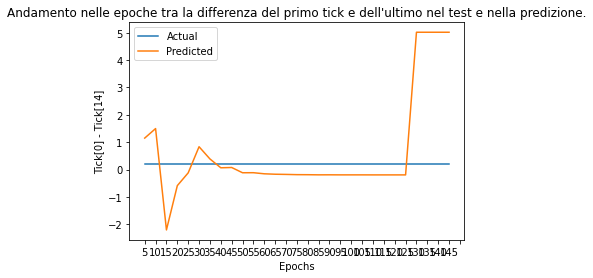

In [26]:
import keras

history_actual = []
history_predicted = []

for epoch in range(5, 150, 5):
  print(f"Model e1d1 trainato per {epoch} epoche: ")
  model = keras.models.load_model(f'/content/e1d1_checkpoints/model{epoch:d}')
  pred = model.predict(X_test)
  for index,i in enumerate(dataset_train.columns):
    scaler = scalers['scaler_'+ str(i)]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])

  #print(y_test[:, 0, 0], y_test[:, 14, 0], pred[:, 0, 0], pred[:, 14, 0])
  print(f"Differenza tra primo e ultimo giorno::::: actual={y_test[:, 0, 0][0] - y_test[:, 14, 0][0]} <-> pred={pred[:, 0, 0][0] - pred[:, 14, 0][0]}")

  history_actual.append(y_test[:, 0, 0][0] - y_test[:, 14, 0][0])
  history_predicted.append(pred[:, 0, 0][0] - pred[:, 14, 0][0])

plt.xticks(np.arange(30), np.arange(5, 150, 5))
plt.plot(history_actual)
plt.plot(history_predicted)
plt.title("Andamento nelle epoche tra la differenza del primo tick e dell'ultimo nel test e nella predizione.")
plt.xlabel('Epochs')
plt.ylabel('Tick[0] - Tick[14]')
plt.legend(['Actual', 'Predicted'])
#plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams['figure.figsize'] = [120, 80]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()

  # Adesso bisogna fare il confronto con i valori veri -y_test!
  #for j in range(1,n_future+1):
  #  diff = y_test[:, j-1, 0] - pred[:, j-1, 0] 
  #  print(f"Tick {j} -> actual={y_test[:, j-1, 0]} predicted={pred[:, j-1, 0]} ==> diff={diff}")

print()

Model e2d2 trainato per 5 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=1.1484375
Model e2d2 trainato per 10 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=1.49609375
Model e2d2 trainato per 15 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-2.20703125
Model e2d2 trainato per 20 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.5888671875
Model e2d2 trainato per 25 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=-0.1220703125
Model e2d2 trainato per 30 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.8330078125
Model e2d2 trainato per 35 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.38671875
Model e2d2 trainato per 40 epoche: 
Differenza tra primo e ultimo giorno::::: actual=0.21999999999934516 <-> pred=0.06

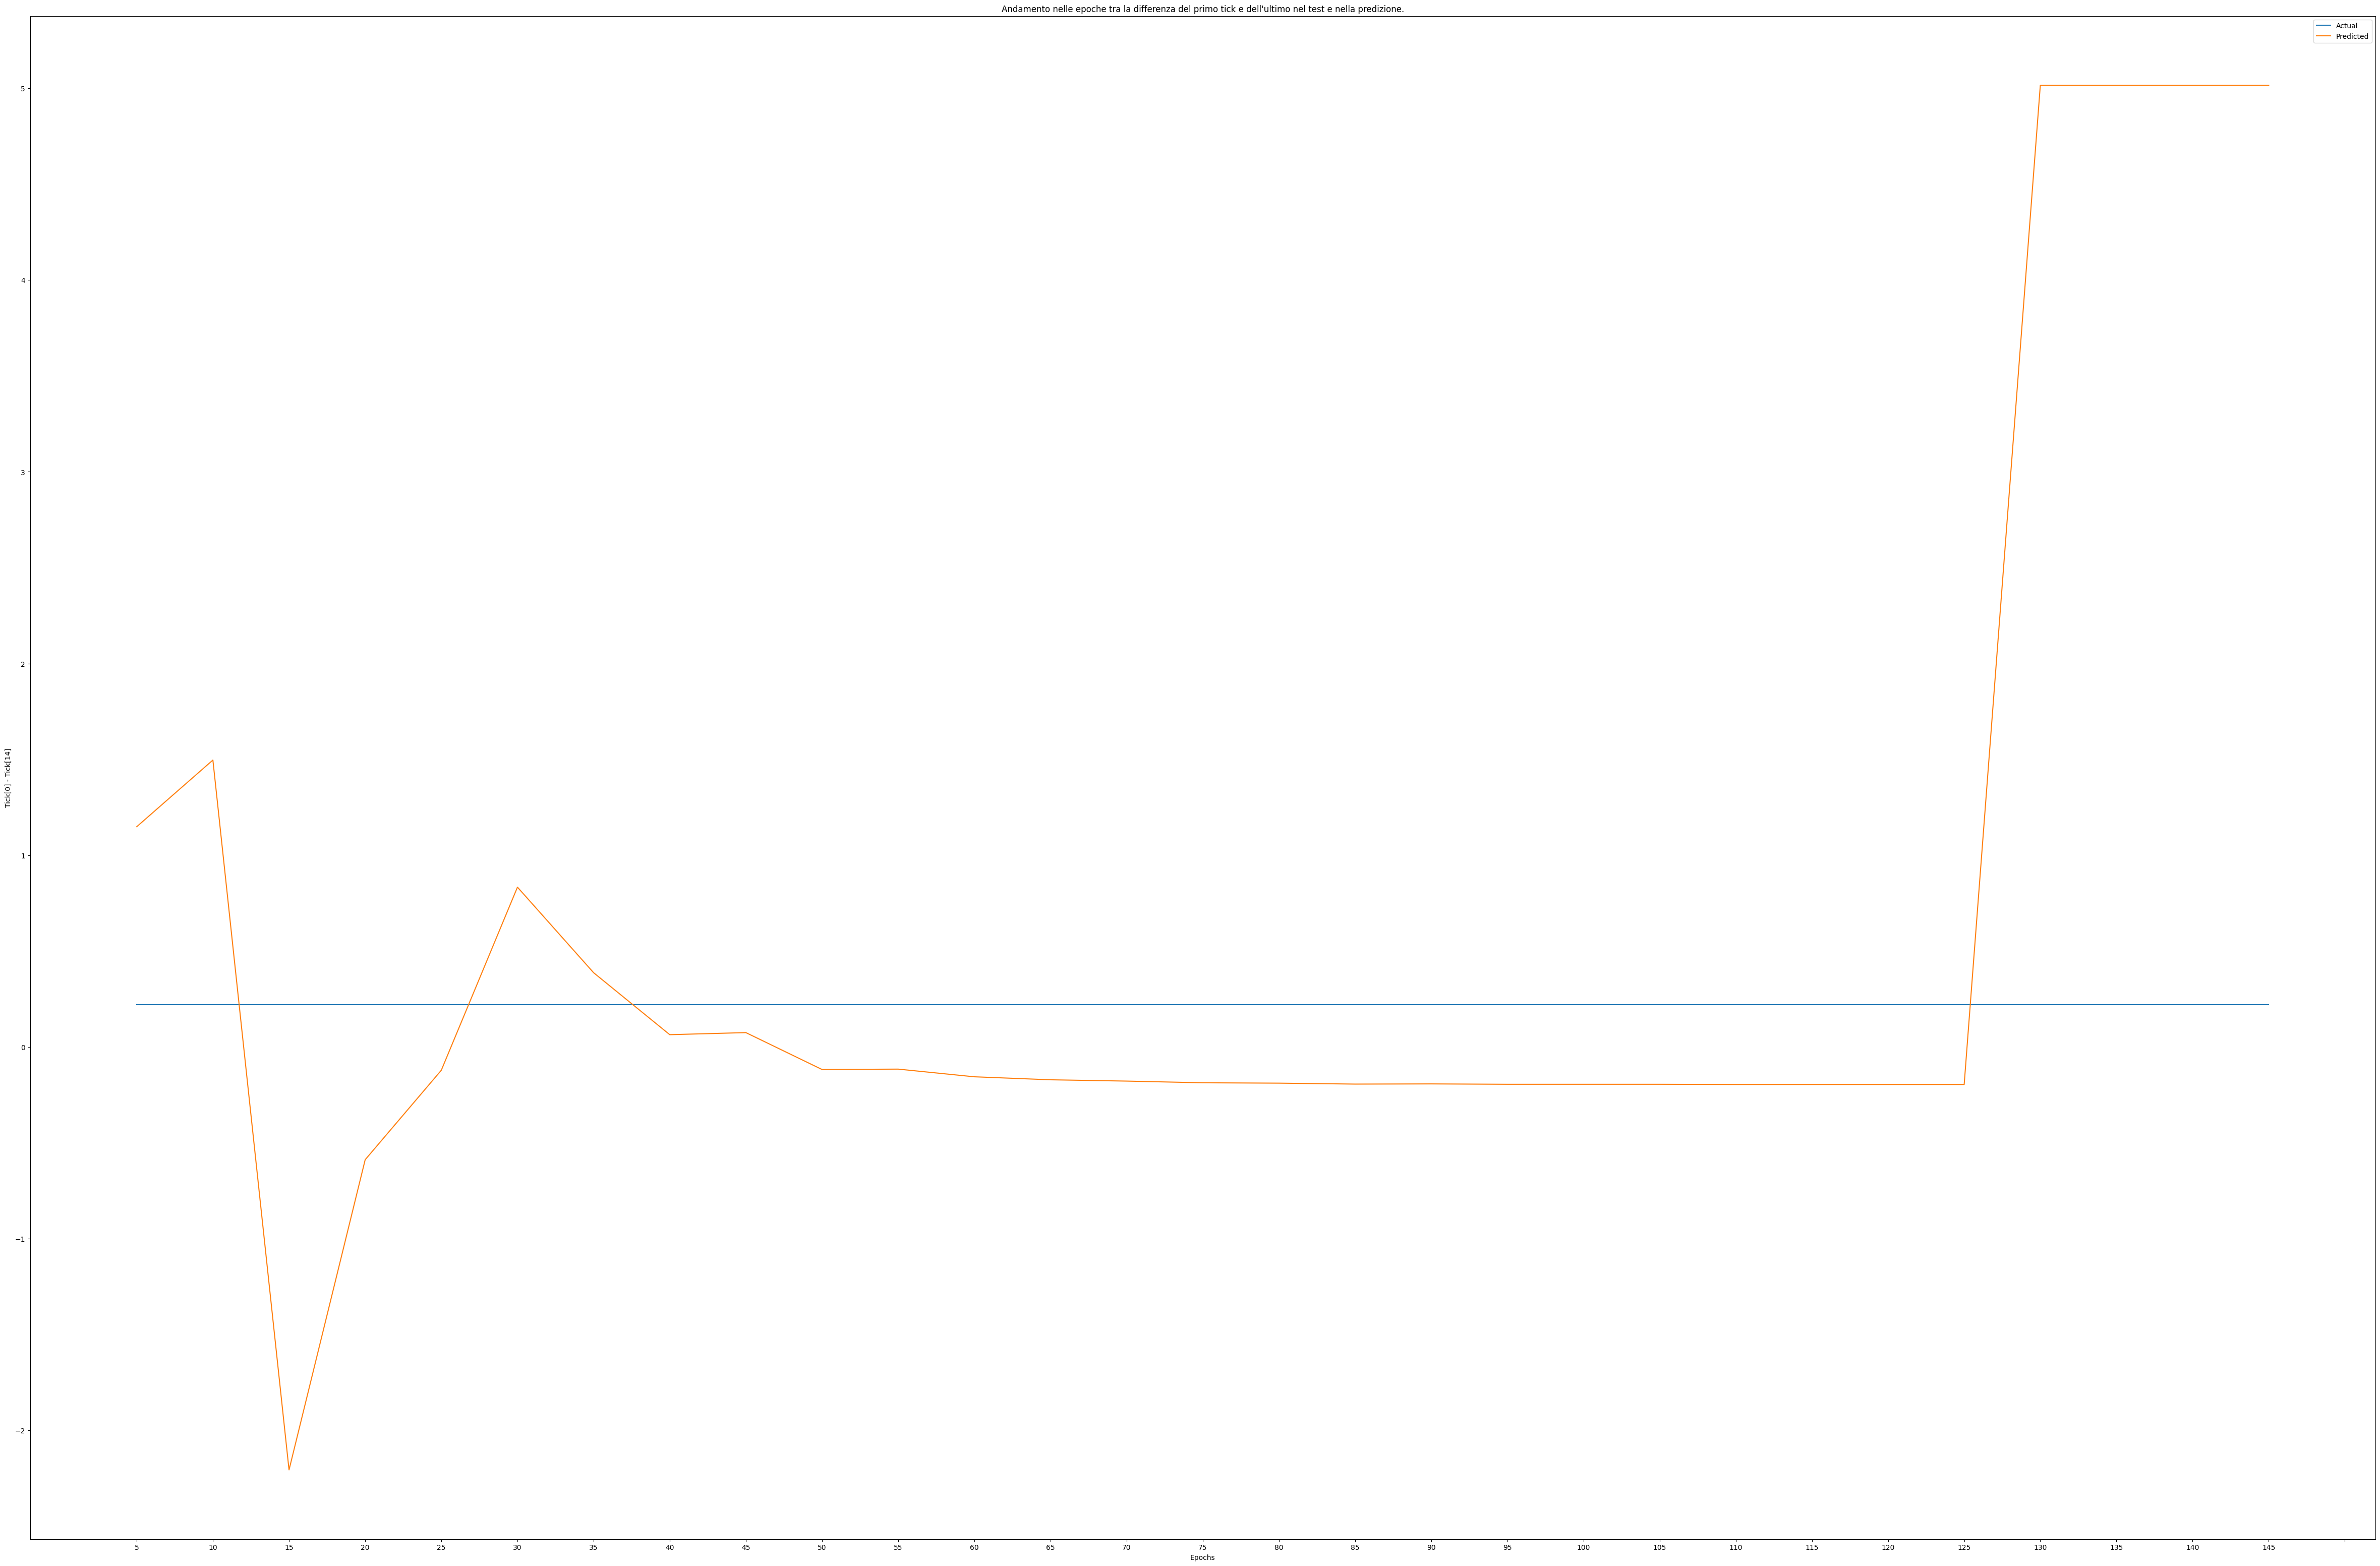

In [28]:
history_actual = []
history_predicted = []

for epoch in range(5, 150, 5):
  print(f"Model e2d2 trainato per {epoch} epoche: ")
  model = keras.models.load_model(f'/content/e1d1_checkpoints/model{epoch:d}')
  pred = model.predict(X_test)
  for index,i in enumerate(dataset_train.columns):
    scaler = scalers['scaler_'+ str(i)]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])

  #print(y_test[:, 0, 0], y_test[:, 14, 0], pred[:, 0, 0], pred[:, 14, 0])
  print(f"Differenza tra primo e ultimo giorno::::: actual={y_test[:, 0, 0][0] - y_test[:, 14, 0][0]} <-> pred={pred[:, 0, 0][0] - pred[:, 14, 0][0]}")

  history_actual.append(y_test[:, 0, 0][0] - y_test[:, 14, 0][0])
  history_predicted.append(pred[:, 0, 0][0] - pred[:, 14, 0][0])

plt.xticks(np.arange(30), np.arange(5, 150, 5))
plt.plot(history_actual)
plt.plot(history_predicted)
plt.title("Andamento nelle epoche tra la differenza del primo tick e dell'ultimo nel test e nella predizione.")
plt.xlabel('Epochs')
plt.ylabel('Tick[0] - Tick[14]')
plt.legend(['Actual', 'Predicted'])
#plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams['figure.figsize'] = [60, 40]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()
plt.close()

  # Adesso bisogna fare il confronto con i valori veri -y_test!
  #for j in range(1,n_future+1):
  #  diff = y_test[:, j-1, 0] - pred[:, j-1, 0] 
  #  print(f"Tick {j} -> actual={y_test[:, j-1, 0]} predicted={pred[:, j-1, 0]} ==> diff={diff}")

print()